# In this notebook, I'm going to first download the CIFAR-10 dataset and then train a MLP on it.
## Here we imported pytorch libraries which we'll going to use in next cells

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torchvision.ops import MLP
from torch import nn, optim
import cv2
from tqdm import tqdm

ModuleNotFoundError: No module named 'numpy'

## In this cell we want to specify the device in which our codes are going to be ran.
### Also the result is printed

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    quit()
print('CUDA')

CUDA


### In this cell, we'ere going to define a list of transforms that we want to apply on data before training

First convert PIL image object to tensor, then apply 0-mean normalizatoin with std of 1

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,)),
])

## Now we're going to download the data (CIFAR10) and sperate it into two parts, train and test
## Also an offline archive is created for CIFAR10 and transformations are done on raw images

In [4]:
train_path = 'ds/train/'
test_path = 'ds/test/'
dstrain = datasets.CIFAR10(train_path, train=True, download=True, transform=transform)
dstest = datasets.CIFAR10(test_path, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


### We have 50,000 training sample images and 10,000 for testing

In [5]:
print(dstrain)
print(dstest)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ds/train/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0,), std=(1,))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ds/test/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0,), std=(1,))
           )


### CIFAR10 contains 10 classes of images, you can see class labels below
### Images are 32*32 RGB and for each class we have 6,000 images
### DS is sperated in 5 trainig batch and 1 test batch each contains 10,000 images
### Images are not divided between training batches uniformly (which means, one batch may contains more image from one class than others)
### But there are exactly 5000 trainig image and 1000 test image for each class

In [7]:
print(len(dstrain.classes))
print(dstrain.classes)

10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Here we defined a loader which is a wrapper around data that can help us divide data into batches and only load those batches that we need. It's saving lots of memory

In [8]:
ldtrain = torch.utils.data.DataLoader(dstrain, batch_size=64, shuffle=True)
ldval = torch.utils.data.DataLoader(dstest, batch_size=64, shuffle=True)

Now let's show a subset of images, to do so, first we converted train set loaded to a python iterator and get the first iteration value out of it. 

In [9]:
dataiter = iter(ldtrain)
images ,labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


Now in this cell, we just printed a batch of the images,<br>
Notice that to do so, we need to move RGB channel to last axis of tensor

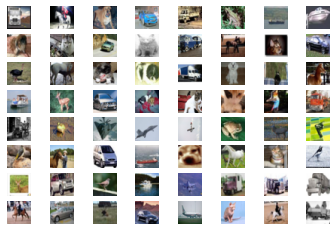

In [10]:
noi = 8
num_of_images = noi * noi
for index in range(1, num_of_images+1):
    img = images[index-1]
    
    _ = plt.subplot(noi,noi, index)
    _ = plt.axis('off')
    _ = plt.imshow(img.moveaxis(0, -1))

Now we're defining the layers of MLP

In [11]:
input_size = 32 * 32 * 3
hidden_size = [128, 128]
output_size = 10

model = nn.Sequential(
    nn.Flatten(), # convert images to vectors
    nn.Linear(input_size, hidden_size[0]), # fully connected
    nn.ReLU(), # fc afunc
    nn.Linear(hidden_size[0],hidden_size[1]), # fully connected
    nn.ReLU(), # fc afunc
    nn.Linear(hidden_size[1],output_size) # output
)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=10, bias=True)
)


binding model object to specified training hardware

In [12]:
_ = model.to(device)

defining learning rate, number of epochs, validation frequency, optimizer and loss function

In [13]:
lr = 0.0001
n_epochs = 18
val_freq = 3
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [14]:
def accuracy(y_pred, y):
    """
    Calculating the accuracy of given batch.
    input(s):
    y_pred (ndarray): predicted logits or the output of the model.
    y (ndarray): labels
    """
    pred_idx = y_pred.max(1, keepdim=True)[1]
    correct = pred_idx.eq(y.view_as(pred_idx)).sum().item()
    return correct / len(y)

In [15]:
history = dict()
history['train_loss']= list()
history['train_acc']= list()
history['val_loss']= list()
history['val_acc']= list()
for epoch in range(n_epochs):
    running_loss = 0
    running_acc = 0

    model.train()
    for idx, (X, y) in enumerate(tqdm(ldtrain)):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(y_hat, y)
    else:
        running_loss = running_loss/ len(ldtrain)
        running_acc = running_acc / len(ldtrain)
        history['train_loss'].append(running_loss)
        history['train_acc'].append(running_acc)
        print(f'Epoch {epoch+1}/{n_epochs} : training loss: {running_loss}, training acc: {running_acc}')




    if epoch% val_freq == val_freq-1:
        running_loss = 0
        running_acc = 0
        model.eval()
        with torch.no_grad():
            for idx, (X, y) in enumerate(tqdm(ldval)):
                X, y = X.to(device), y.to(device) 
                y_hat = model(X)
                loss = criterion(y_hat, y)

                running_loss += loss.item()
                running_acc += accuracy(y_hat, y)
            else:
                running_loss = running_loss/ len(ldval)
                running_acc = running_acc / len(ldval)
                history['val_loss'].append(running_loss)
                history['val_acc'].append(running_acc)
                print(f'Epoch {epoch+1}/{n_epochs} : validation loss: {running_loss}, validation acc: {running_acc}')

100%|██████████| 782/782 [00:15<00:00, 49.80it/s]


Epoch 1/18 : training loss: 1.8410381807390686, training acc: 0.3371962915601023


100%|██████████| 782/782 [00:11<00:00, 66.39it/s]


Epoch 2/18 : training loss: 1.6634510141199508, training acc: 0.40421195652173914


100%|██████████| 782/782 [00:11<00:00, 65.59it/s]


Epoch 3/18 : training loss: 1.5930712617876586, training acc: 0.4326446611253197


100%|██████████| 157/157 [00:02<00:00, 73.68it/s]


Epoch 3/18 : validation loss: 1.634519583100726, validation acc: 0.40764331210191085


100%|██████████| 782/782 [00:11<00:00, 66.40it/s]


Epoch 4/18 : training loss: 1.5428188403549097, training acc: 0.44751039002557547


100%|██████████| 782/782 [00:11<00:00, 67.01it/s]


Epoch 5/18 : training loss: 1.4995562586638018, training acc: 0.4654331841432225


100%|██████████| 782/782 [00:11<00:00, 67.94it/s]


Epoch 6/18 : training loss: 1.4661989655641035, training acc: 0.47372522378516624


100%|██████████| 157/157 [00:02<00:00, 75.72it/s]


Epoch 6/18 : validation loss: 1.515021848071153, validation acc: 0.4573049363057325


100%|██████████| 782/782 [00:11<00:00, 67.40it/s]


Epoch 7/18 : training loss: 1.4389170200928398, training acc: 0.48633312020460356


100%|██████████| 782/782 [00:11<00:00, 66.80it/s]


Epoch 8/18 : training loss: 1.4206816547971857, training acc: 0.494605179028133


100%|██████████| 782/782 [00:11<00:00, 66.61it/s]


Epoch 9/18 : training loss: 1.3929145735547976, training acc: 0.5005794437340153


100%|██████████| 157/157 [00:02<00:00, 74.38it/s]


Epoch 9/18 : validation loss: 1.4614717223841673, validation acc: 0.4759156050955414


100%|██████████| 782/782 [00:11<00:00, 66.20it/s]


Epoch 10/18 : training loss: 1.3802023978946765, training acc: 0.5088315217391305


100%|██████████| 782/782 [00:11<00:00, 65.83it/s]


Epoch 11/18 : training loss: 1.3652343882624145, training acc: 0.5119285485933504


100%|██████████| 782/782 [00:11<00:00, 67.48it/s]


Epoch 12/18 : training loss: 1.345026208464142, training acc: 0.516983695652174


100%|██████████| 157/157 [00:02<00:00, 73.20it/s]


Epoch 12/18 : validation loss: 1.4275208377534416, validation acc: 0.49731289808917195


100%|██████████| 782/782 [00:11<00:00, 67.70it/s]


Epoch 13/18 : training loss: 1.3317835496362214, training acc: 0.5239570012787724


100%|██████████| 782/782 [00:11<00:00, 67.36it/s]


Epoch 14/18 : training loss: 1.318328461607399, training acc: 0.5298313618925832


100%|██████████| 782/782 [00:11<00:00, 67.20it/s]


Epoch 15/18 : training loss: 1.3067856392134791, training acc: 0.533048273657289


100%|██████████| 157/157 [00:02<00:00, 74.06it/s]


Epoch 15/18 : validation loss: 1.4364277382565152, validation acc: 0.4925358280254777


100%|██████████| 782/782 [00:11<00:00, 68.23it/s]


Epoch 16/18 : training loss: 1.2966310823969829, training acc: 0.5366648017902813


100%|██████████| 782/782 [00:11<00:00, 66.96it/s]


Epoch 17/18 : training loss: 1.2844787387896681, training acc: 0.5417599104859335


100%|██████████| 782/782 [00:11<00:00, 66.63it/s]


Epoch 18/18 : training loss: 1.2716703494186596, training acc: 0.5447969948849105


100%|██████████| 157/157 [00:02<00:00, 72.76it/s]

Epoch 18/18 : validation loss: 1.411198246251246, validation acc: 0.5033837579617835


Text(0, 0.5, 'acc')

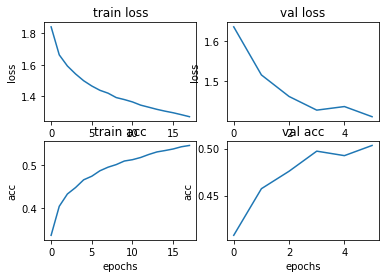

In [16]:
plt.subplot(2,2,1)
plt.title('train loss')
plt.plot(history['train_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
#plt.show()

plt.subplot(2,2,2)
plt.title('val loss')
plt.plot(history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
#plt.show()

plt.subplot(2,2,3)
plt.title('train acc')
plt.plot(history['train_acc'])
plt.xlabel("epochs")
plt.ylabel("acc")
#plt.show()

plt.subplot(2,2,4)
plt.title('val acc')
plt.plot(history['val_acc'])
plt.xlabel("epochs")
plt.ylabel("acc")
#plt.show()

In [17]:
assert False

AssertionError: 